In [2]:
%autosave 0
from pandas import read_csv
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import utils
from keras.utils import np_utils


from sklearn.model_selection import cross_val_score, KFold


# from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import nltk

from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

# ignore Warning
import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

Autosave disabled


Using TensorFlow backend.


# Transformation du jeu de données pour evoluer vers un modèle de Classification

In [3]:
lookforopti = False

In [4]:
df = read_csv("Base_Files/movies2.csv")

In [5]:
df.sample(3)

,id,imdb_id,title,synopsis,rating,genre,prod_budget,duration,release_date,director,people,produceur,country,writer,target,box_office
1340,1341,tt0312004,Wallace et Gromit - Le mystère du lapin-garou,"Wallace and his loyal dog, Gromit, set out to ...",TP,"Animation, Adventure, Comedy, Family, Fantasy,...",30000000,85,2005-10-12,"Steve Box, Nick Park","Peter Sallis, Ralph Fiennes, Helena Bonham Car...",Dreamworks,"UK, USA","Steve Box (screenplay by), Nick Park (screenpl...",7.4,192615000
7130,7131,tt0251433,Time and Tide,"Tyler is a restless, streetwise 21-year-old Ho...",-12,"Action, Crime, Drama, Thriller",0,113,2001-12-12,Hark Tsui,"Nicholas Tse, Wu Bai, Candy Lo, Cathy Tsui",TriStar Pictures,"Hong Kong, China","Koan Hui, Hark Tsui",6.9,243978
7417,7418,tt5451118,303,"Two university students, Jule and Jan, leave B...",TP,"Comedy, Drama, Romance",0,145,2019-07-24,Hans Weingartner,"Mala Emde, Anton Spieker, Arndt Schwering-Sohn...",NaN,Germany,"Hans Weingartner (screenplay), Silke Eggert (s...",7.6,395352


In [6]:
col_drop = ("box_office",'imdb_id','id','prod_budget')
for i in col_drop :
    df = df.drop([i], axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8756 entries, 0 to 8755
Data columns (total 12 columns):
title           8755 non-null object
synopsis        8756 non-null object
rating          8756 non-null object
genre           8756 non-null object
duration        8756 non-null int64
release_date    8756 non-null object
director        8756 non-null object
people          8752 non-null object
produceur       8056 non-null object
country         8756 non-null object
writer          8674 non-null object
target          8756 non-null float64
dtypes: float64(1), int64(1), object(10)
memory usage: 821.0+ KB


In [8]:
df["target"].shape

(8756,)

In [9]:
def classifier_target():
    row_lock = 0
    count_class_0 = 0
    count_class_1 = 0
    count_class_2 = 0

    for i in tqdm(df["target"]) :
        if i <= 6 :
            df.loc[row_lock,"target_class"] = 0
            count_class_0 += 1
            
        elif i > 6 and i <= 6.9 :
            df.loc[row_lock,"target_class"] = 1
            count_class_1 += 1
            
        else :
            df.loc[row_lock,"target_class"] = 2
            count_class_2 += 1
        row_lock +=1
    
    
    print(f"class 0 : {count_class_0} --- class 1 : {count_class_1} ---- class 2 : {count_class_2}")
    
classifier_target() 


class 0 : 2490 --- class 1 : 3211 ---- class 2 : 3055


In [10]:
df = df.dropna(axis=0)

In [11]:
y_full = df["target_class"]
x_full = df.drop(["target_class","target"], axis=1)

x_full.shape, y_full.shape

((7978, 11), (7978,))

# Split et Preprocessing des données

In [12]:
seed = 69
np.random.seed(seed)

In [13]:
# stopW = nltk.corpus.stopwords.words('english')

# count_vect = CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None,
# lowercase=True, preprocessor=None, tokenizer=None, stop_words=stopW, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), 
# analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False)



# x_full["produceur"] = count_vect.fit_transform(x_full["produceur"])
# x_full["produceur"]

In [14]:
# tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# X_full = tfidf_transformer.fit_transform(X_full)
# X_full.shape

In [15]:
# tfid_vectorizer = TfidfVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None,
# lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words=None, token_pattern='(?u)\b\w\w+\b',
# ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, 
# dtype=<class 'numpy.float64'>, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# X_full = tfid_vectorizer.fit_transform(X_full)
# X_full.shape

In [16]:
col_labelEnco = ('title','synopsis','rating','genre','release_date','director','people','produceur','country','writer')

for i in col_labelEnco:

    lbl = LabelEncoder() 
    x_full[i] = lbl.fit_transform(x_full[i])

oe = OrdinalEncoder() 
x_full["release_date"] = lbl.fit_transform(x_full["release_date"])   

In [17]:
print(utils.multiclass.type_of_target(x_full))
print(utils.multiclass.type_of_target(y_full))

multiclass-multioutput
multiclass


In [18]:
x_train, x_val, y_train, y_val = train_test_split(x_full,y_full, test_size=0.2, random_state=seed)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((6382, 11), (1596, 11), (6382,), (1596,))

# Creation et entrainement du modèle Classifier

In [19]:
clf = OneVsRestClassifier(SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, 
                              tol=0.001, cache_size=200, class_weight=None, verbose=True, max_iter=-1,
                              decision_function_shape='ovr', break_ties=False,random_state=None,)).fit(x_train, y_train)
clf.score(x_train,y_train)

[LibSVM][LibSVM][LibSVM]

0.4791601378878095

In [20]:
pred = clf.predict(x_val)
pred

array([0., 1., 0., ..., 0., 2., 2.])

In [21]:
print('Accuracy:', accuracy_score(y_val, pred))

Accuracy: 0.41353383458646614


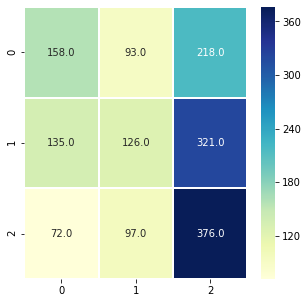

In [22]:
plt.figure(figsize=(5,5))
conf = confusion_matrix(y_val, pred)
ax = sns.heatmap(conf,fmt=".1f",annot=True, linewidths=.9,cmap="YlGnBu")

# Creation et entrainement du modèle DeepLearning

In [23]:
df = read_csv("Base_Files/movies2.csv")

In [24]:
col_drop = ("box_office",'imdb_id','id','prod_budget')
for i in col_drop :
    df = df.drop([i], axis=1)

In [25]:
def classifier_target_oh():
    row_lock = 0
    count_class_1 = 0
    count_class_2 = 0
    count_class_3 = 0

    for i in tqdm(df["target"]) :
        if i <= 6 :
            df.loc[row_lock,"target_class_1"] = 1
            count_class_1 += 1
            
        elif i > 6 and i <= 6.9 :
            df.loc[row_lock,"target_class_2"] = 1
            count_class_2 += 1
        else :
            df.loc[row_lock,"target_class_3"] = 1
            count_class_3 += 1
        row_lock +=1
    
    
    print(f"class 1 : {count_class_1} --- class 2 : {count_class_2} ---- class 3 : {count_class_3}")
    
classifier_target_oh() 


class 1 : 2490 --- class 2 : 3211 ---- class 3 : 3055


In [26]:
df["target_class_1"] = df["target_class_1"].fillna(0)
df["target_class_2"] = df["target_class_2"].fillna(0)
df["target_class_3"] = df["target_class_3"].fillna(0)

df = df.dropna(axis=0)

In [27]:
y_full = pd.DataFrame()
y_full["target_class_1"] = df["target_class_1"]
y_full["target_class_2"] = df["target_class_2"]
y_full["target_class_3"] = df["target_class_3"]

x_full = df.drop(["target_class_1","target_class_2","target_class_3","target"], axis=1)

x_full.shape, y_full.shape

((7978, 11), (7978, 3))

In [28]:
col_labelEnco = ('title','synopsis','rating','genre','release_date','director','people','produceur','country','writer')

# transformation des colonnes en categorie INT/FLOAT
for i in col_labelEnco:

    lbl = LabelEncoder() 
    x_full[i] = lbl.fit_transform(x_full[i])

oe = OrdinalEncoder() 
x_full["release_date"] = lbl.fit_transform(x_full["release_date"]) 

In [29]:
print(utils.multiclass.type_of_target(x_full))
print(utils.multiclass.type_of_target(y_full))

multiclass-multioutput
multilabel-indicator


In [30]:
x_train_d, x_val_d, y_train_d, y_val_d = train_test_split(x_full,y_full, test_size=0.2, random_state=seed)
x_train_d.shape, x_val_d.shape, y_train_d.shape, y_val_d.shape

((6382, 11), (1596, 11), (6382, 3), (1596, 3))

In [31]:
def create_deep_classifier(neurons=40):
    
    dim = x_train.shape[1]
    model = Sequential()
    
    # initialisation du modèle et création de la couche cachée
    model.add(Dense(neurons, input_dim=dim, activation="relu", kernel_initializer="uniform"))
    model.add(Dropout(rate=0.01))
    
    # création d'une deuxiéme couche cachée
    model.add(Dense((20), activation="relu", kernel_initializer="uniform"))
    model.add(Dropout(rate=0.1))
    
    # création d'une deuxiéme couche cachée
    model.add(Dense((10), activation="relu", kernel_initializer="uniform"))
    model.add(Dropout(rate=0.1))
    
    # création de la couche de sortie
    model.add(Dense(3, activation="softmax", kernel_initializer="uniform"))
              
    # Compilation du modèle
    model.compile(optimizer="nadam", loss ="categorical_crossentropy", metrics = ["accuracy"])
    
    return model

########################## Paramétre disponible pour la creation d'une couche cachée #############################

# keras.layers.Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#                    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, 
#                    activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
              
########################## Paramétre disponible pour la compilation d'un modèle #############################
            
# compile(optimizer, loss=None, metrics=None, loss_weights=None, 
#        sample_weight_mode=None, weighted_metrics=None, target_tensors=None)

In [32]:
model = create_deep_classifier() 
history = model.fit(x_train_d,y_train_d, epochs=200, batch_size=30, validation_data=(x_val_d, y_val_d))

Train on 6382 samples, validate on 1596 samples
Epoch 1/200
6382/6382 [==============================] - 2s 235us/step - loss: 1.0939 - accuracy: 0.3692 - val_loss: 1.0903 - val_accuracy: 0.3960
Epoch 2/200
6382/6382 [==============================] - 1s 117us/step - loss: 1.0720 - accuracy: 0.4091 - val_loss: 1.0647 - val_accuracy: 0.4048
Epoch 3/200
6382/6382 [==============================] - 1s 127us/step - loss: 1.0669 - accuracy: 0.4173 - val_loss: 1.0576 - val_accuracy: 0.4091
Epoch 4/200
6382/6382 [==============================] - 1s 125us/step - loss: 1.0642 - accuracy: 0.4166 - val_loss: 1.0686 - val_accuracy: 0.4110
Epoch 5/200
6382/6382 [==============================] - 1s 141us/step - loss: 1.0635 - accuracy: 0.4137 - val_loss: 1.0615 - val_accuracy: 0.4129
Epoch 6/200
6382/6382 [==============================] - 1s 128us/step - loss: 1.0622 - accuracy: 0.4121 - val_loss: 1.0588 - val_accuracy: 0.4117
Epoch 7/200
6382/6382 [==============================] - 1s 146us/step

6382/6382 [==============================] - 1s 117us/step - loss: 1.0108 - accuracy: 0.4693 - val_loss: 1.0234 - val_accuracy: 0.4455
Epoch 57/200
6382/6382 [==============================] - 1s 121us/step - loss: 1.0103 - accuracy: 0.4699 - val_loss: 1.0129 - val_accuracy: 0.4630
Epoch 58/200
6382/6382 [==============================] - 1s 118us/step - loss: 1.0109 - accuracy: 0.4694 - val_loss: 1.0038 - val_accuracy: 0.4706
Epoch 59/200
6382/6382 [==============================] - 1s 117us/step - loss: 1.0080 - accuracy: 0.4704 - val_loss: 1.0127 - val_accuracy: 0.4643
Epoch 60/200
6382/6382 [==============================] - 1s 118us/step - loss: 1.0083 - accuracy: 0.4770 - val_loss: 0.9997 - val_accuracy: 0.4731
Epoch 61/200
6382/6382 [==============================] - 1s 117us/step - loss: 1.0083 - accuracy: 0.4683 - val_loss: 0.9990 - val_accuracy: 0.4887
Epoch 62/200
6382/6382 [==============================] - 1s 120us/step - loss: 1.0094 - accuracy: 0.4646 - val_loss: 1.0086 

6382/6382 [==============================] - 1s 131us/step - loss: 1.0017 - accuracy: 0.4777 - val_loss: 1.0055 - val_accuracy: 0.4787
Epoch 112/200
6382/6382 [==============================] - 1s 124us/step - loss: 1.0099 - accuracy: 0.4660 - val_loss: 1.0070 - val_accuracy: 0.4856
Epoch 113/200
6382/6382 [==============================] - 1s 126us/step - loss: 1.0108 - accuracy: 0.4715 - val_loss: 1.0115 - val_accuracy: 0.4793
Epoch 114/200
6382/6382 [==============================] - 1s 120us/step - loss: 1.0070 - accuracy: 0.4749 - val_loss: 1.0036 - val_accuracy: 0.4900
Epoch 115/200
6382/6382 [==============================] - 1s 127us/step - loss: 1.0253 - accuracy: 0.4539 - val_loss: 1.0432 - val_accuracy: 0.4054
Epoch 116/200
6382/6382 [==============================] - 1s 129us/step - loss: 1.0106 - accuracy: 0.4658 - val_loss: 1.0300 - val_accuracy: 0.4781
Epoch 117/200
6382/6382 [==============================] - 1s 121us/step - loss: 1.0094 - accuracy: 0.4721 - val_loss: 1

6382/6382 [==============================] - 1s 193us/step - loss: 1.0060 - accuracy: 0.4785 - val_loss: 1.0122 - val_accuracy: 0.4637
Epoch 167/200
6382/6382 [==============================] - 1s 174us/step - loss: 1.0144 - accuracy: 0.4632 - val_loss: 1.0184 - val_accuracy: 0.4649
Epoch 168/200
6382/6382 [==============================] - 1s 153us/step - loss: 1.0100 - accuracy: 0.4624 - val_loss: 1.0120 - val_accuracy: 0.4662
Epoch 169/200
6382/6382 [==============================] - 1s 154us/step - loss: 1.0039 - accuracy: 0.4683 - val_loss: 0.9996 - val_accuracy: 0.4812
Epoch 170/200
6382/6382 [==============================] - 1s 155us/step - loss: 1.0068 - accuracy: 0.4727 - val_loss: 1.0248 - val_accuracy: 0.4555
Epoch 171/200
6382/6382 [==============================] - 1s 163us/step - loss: 1.0050 - accuracy: 0.4720 - val_loss: 1.0052 - val_accuracy: 0.4768
Epoch 172/200
6382/6382 [==============================] - 1s 144us/step - loss: 1.0099 - accuracy: 0.4636 - val_loss: 1

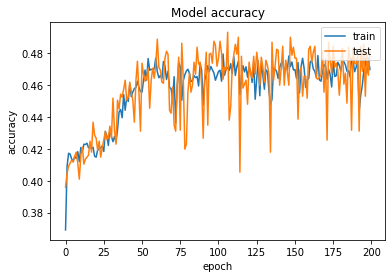

In [33]:
def hist_foll(metrics):
    plt.plot(history.history[f'{metrics}'])
    plt.plot(history.history[f"val_{metrics}"])
    plt.grid = True
    plt.title(f'Model {metrics}')
    plt.ylabel(f'{metrics}')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show

hist_foll('accuracy')

In [34]:
estimator = KerasClassifier(build_fn=create_deep_classifier, epochs=200, batch_size=30, verbose=0)


In [35]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [36]:
results = cross_val_score(estimator, x_train_d, y_train_d, cv=kfold)
print(f"Baseline: {round(results.mean()*100,2)} % {(round(results.std()*100,2))}")

Baseline: 45.0 % 4.18


In [37]:
pred_d = model.predict(x_val_d)

In [38]:
pred_d.shape,y_val_d.shape

((1596, 3), (1596, 3))

In [39]:
results = cross_val_score(estimator, x_val_d, y_val_d, cv=kfold)
print(f"Baseline: {round(results.mean()*100,2)} % {(round(results.std()*100,2))}")

Baseline: 41.05 % 5.06


In [45]:
for i in pred_d :
    print(i)
    for v in i :
        print(v)

[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.3502966
0.1934853
[0.3128564  0.39041722 0.29672638]
0.3128564
0.39041722
0.29672638
[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.3502966
0.1934853
[0.25355363 0.4076665  0.33877993]
0.25355363
0.4076665
0.33877993
[0.17048372 0.39283663 0.43667963]
0.17048372
0.39283663
0.43667963
[0.2601095  0.4078134  0.33207715]
0.2601095
0.4078134
0.33207715
[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.3502966
0.1934853
[0.10430989 0.30523494 0.5904552 ]
0.104309894
0.30523494
0.5904552
[0.30515915 0.40847358 0.28636718]
0.30515915
0.40847358
0.28636718
[0.0588655  0.2902318  0.65090275]
0.058865502
0.2902318
0.65090275
[0.20604813 0.37934238 0.4146095 ]
0.20604813
0.37934238
0.4146095
[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.3502966
0.1934853
[0.14567234 0.34399447 0.51033324]
0.14567234
0.34399447
0.51033324
[0.16850992 0.39212447 0.4393656 ]
0.16850992
0.39212447
0.4393656
[0.1931042  0.37554383 0.43135193]
0.1931042
0.37554383
0.4313

0.3502966
0.1934853
[1.0256398e-07 7.0901122e-04 9.9929082e-01]
1.0256398e-07
0.0007090112
0.9992908
[0.22957103 0.39173234 0.37869665]
0.22957103
0.39173234
0.37869665
[0.24423486 0.40723783 0.34852728]
0.24423486
0.40723783
0.34852728
[0.2660148  0.40784055 0.3261447 ]
0.2660148
0.40784055
0.3261447
[0.30608156 0.40561208 0.28830636]
0.30608156
0.40561208
0.28830636
[0.18813278 0.3983391  0.4135281 ]
0.18813278
0.3983391
0.4135281
[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.3502966
0.1934853
[0.2740923  0.40772194 0.3181858 ]
0.2740923
0.40772194
0.3181858
[0.2506878  0.40756258 0.34174955]
0.2506878
0.40756258
0.34174955
[0.19970888 0.40117022 0.39912093]
0.19970888
0.40117022
0.39912093
[0.12532912 0.35665116 0.51801974]
0.12532912
0.35665116
0.51801974
[0.27486733 0.4077013  0.31743133]
0.27486733
0.4077013
0.31743133
[0.34481037 0.40092176 0.25426787]
0.34481037
0.40092176
0.25426787
[0.2639422  0.40784213 0.3282157 ]
0.2639422
0.40784213
0.3282157
[0.18123724 0.38597396 0.43

0.45621818
0.3502966
0.1934853
[0.43018526 0.3631991  0.20661566]
0.43018526
0.3631991
0.20661566
[0.205385   0.40235242 0.39226258]
0.205385
0.40235242
0.39226258
[0.45166332 0.35258436 0.19575237]
0.45166332
0.35258436
0.19575237
[0.20566513 0.4024074  0.39192748]
0.20566513
0.4024074
0.39192748
[0.3091653  0.40527928 0.28555545]
0.3091653
0.40527928
0.28555545
[0.16520266 0.35862568 0.47617167]
0.16520266
0.35862568
0.47617167
[0.15836716 0.35378796 0.48784482]
0.15836716
0.35378796
0.48784482
[0.25897667 0.40065032 0.3403731 ]
0.25897667
0.40065032
0.3403731
[0.26624045 0.40234575 0.33141378]
0.26624045
0.40234575
0.33141378
[0.34691653 0.4006051  0.25247827]
0.34691653
0.4006051
0.25247827
[0.34057727 0.40106246 0.25836027]
0.34057727
0.40106246
0.25836027
[0.21521957 0.40409994 0.3806805 ]
0.21521957
0.40409994
0.3806805
[0.14870813 0.3575063  0.4937855 ]
0.14870813
0.3575063
0.4937855
[0.3128564  0.39041722 0.29672638]
0.3128564
0.39041722
0.29672638
[0.45621818 0.3502966  0.193

0.2500372
0.4075356
0.3424272
[0.14230771 0.35092798 0.5067643 ]
0.14230771
0.35092798
0.5067643
[0.21824418 0.40456384 0.377192  ]
0.21824418
0.40456384
0.377192
[0.35223952 0.39904365 0.24871683]
0.35223952
0.39904365
0.24871683
[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.3502966
0.1934853
[0.29468715 0.4066505  0.2986623 ]
0.29468715
0.4066505
0.2986623
[0.1468722  0.38287696 0.47025084]
0.1468722
0.38287696
0.47025084
[3.3001073e-05 1.0810848e-02 9.8915613e-01]
3.3001073e-05
0.010810848
0.9891561
[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.3502966
0.1934853
[0.19493897 0.37650937 0.42855164]
0.19493897
0.37650937
0.42855164
[0.1599204  0.3549131  0.48516655]
0.1599204
0.3549131
0.48516655
[0.27633384 0.40765798 0.31600815]
0.27633384
0.40765798
0.31600815
[7.2882971e-04 3.6238696e-02 9.6303248e-01]
0.0007288297
0.036238696
0.9630325
[0.35223952 0.39904365 0.24871683]
0.35223952
0.39904365
0.24871683
[0.3076142  0.40544936 0.2869364 ]
0.3076142
0.40544936
0.2869364
[0.456218

0.40784237
0.32810056
[0.34973454 0.39988276 0.2503827 ]
0.34973454
0.39988276
0.2503827
[0.24430759 0.4072422  0.34845018]
0.24430759
0.4072422
0.34845018
[0.29382497 0.40671656 0.29945847]
0.29382497
0.40671656
0.29945847
[0.41438484 0.37081805 0.2147971 ]
0.41438484
0.37081805
0.2147971
[0.0957101  0.29560423 0.6086857 ]
0.0957101
0.29560423
0.6086857
[0.31169593 0.4049901  0.28331402]
0.31169593
0.4049901
0.28331402
[0.06768764 0.31483746 0.6174749 ]
0.06768764
0.31483746
0.6174749
[0.33018824 0.40245157 0.2673602 ]
0.33018824
0.40245157
0.2673602
[0.2542493  0.40768802 0.33806267]
0.2542493
0.40768802
0.33806267
[0.33831337 0.40111846 0.2605682 ]
0.33831337
0.40111846
0.2605682
[0.0700424  0.31808105 0.61187655]
0.0700424
0.31808105
0.61187655
[0.00909155 0.12142567 0.86948276]
0.0090915505
0.121425666
0.86948276
[0.37760606 0.38787878 0.2345151 ]
0.37760606
0.38787878
0.2345151
[0.14582705 0.38235813 0.47181487]
0.14582705
0.38235813
0.47181487
[0.45621818 0.3502966  0.1934853 ]


0.06396791
0.93418
[0.34624195 0.40087909 0.25287896]
0.34624195
0.40087909
0.25287896
[0.27979648 0.40753335 0.31267023]
0.27979648
0.40753335
0.31267023
[0.40130946 0.37699488 0.22169563]
0.40130946
0.37699488
0.22169563
[0.41029117 0.37276462 0.21694417]
0.41029117
0.37276462
0.21694417
[0.1324001  0.37502477 0.49257514]
0.1324001
0.37502477
0.49257514
[0.05993908 0.30329928 0.6367616 ]
0.05993908
0.30329928
0.6367616
[0.18857214 0.3984573  0.41297063]
0.18857214
0.3984573
0.41297063
[0.17013475 0.39271218 0.437153  ]
0.17013475
0.39271218
0.437153
[0.21938473 0.38781938 0.39279586]
0.21938473
0.38781938
0.39279586
[0.00151252 0.05176798 0.9467195 ]
0.0015125165
0.051767975
0.9467195
[7.3401403e-04 4.4755738e-02 9.5451021e-01]
0.00073401403
0.04475574
0.9545102
[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.3502966
0.1934853
[0.03564317 0.23653264 0.72782415]
0.03564317
0.23653264
0.72782415
[0.24372387 0.40720665 0.34906948]
0.24372387
0.40720665
0.34906948
[0.3266874  0.4029882  

0.1495442
0.35701147
0.49344426
[0.15481246 0.35115454 0.49403304]
0.15481246
0.35115454
0.49403304
[0.1579978  0.38797432 0.45402798]
0.1579978
0.38797432
0.45402798
[0.3379832  0.40116584 0.26085097]
0.3379832
0.40116584
0.26085097
[0.34059462 0.401062   0.25834343]
0.34059462
0.401062
0.25834343
[0.0646573  0.31048974 0.6248529 ]
0.0646573
0.31048974
0.6248529
[0.21909836 0.40468878 0.37621284]
0.21909836
0.40468878
0.37621284
[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.3502966
0.1934853
[0.13739283 0.3369974  0.5256098 ]
0.13739283
0.3369974
0.5256098
[0.26628283 0.40783945 0.32587776]
0.26628283
0.40783945
0.32587776
[0.2184744  0.40459776 0.3769278 ]
0.2184744
0.40459776
0.3769278
[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.3502966
0.1934853
[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.3502966
0.1934853
[0.20079237 0.37947702 0.4197306 ]
0.20079237
0.37947702
0.4197306
[0.03743376 0.25956678 0.7029994 ]
0.03743376
0.25956678
0.7029994
[0.2288434  0.40593025 0.3652264 ]

0.15478598
0.35113463
0.49407944
[0.00776418 0.10997295 0.8822628 ]
0.007764175
0.10997295
0.8822628
[0.2695268  0.4078107  0.32266247]
0.2695268
0.4078107
0.32266247
[0.14454052 0.34306744 0.51239204]
0.14454052
0.34306744
0.51239204
[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.3502966
0.1934853
[0.30500683 0.40572298 0.2892702 ]
0.30500683
0.40572298
0.2892702
[0.41034576 0.37273878 0.21691549]
0.41034576
0.37273878
0.21691549
[0.26579103 0.4022464  0.33196256]
0.26579103
0.4022464
0.33196256
[0.3337344  0.40188205 0.26438352]
0.3337344
0.40188205
0.26438352
[0.30883282 0.4053162  0.28585097]
0.30883282
0.4053162
0.28585097
[0.21131137 0.40344995 0.38523868]
0.21131137
0.40344995
0.38523868
[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.3502966
0.1934853
[0.20287791 0.40184638 0.3952757 ]
0.20287791
0.40184638
0.3952757
[4.9026957e-04 3.1018663e-02 9.6849108e-01]
0.00049026957
0.031018663
0.9684911
[0.2693927  0.40781248 0.32279485]
0.2693927
0.40781248
0.32279485
[0.13938138 0.3

0.38022268
0.386698
0.23307934
[0.2792704  0.40491676 0.3158128 ]
0.2792704
0.40491676
0.3158128
[0.26932392 0.40300798 0.32766807]
0.26932392
0.40300798
0.32766807
[0.31289312 0.40484825 0.28225854]
0.31289312
0.40484825
0.28225854
[0.32069853 0.4038463  0.27545527]
0.32069853
0.4038463
0.27545527
[0.1504457  0.34780502 0.5017492 ]
0.1504457
0.34780502
0.5017492
[0.14405926 0.38146406 0.47447667]
0.14405926
0.38146406
0.47447667
[0.19535087 0.3767238  0.42792532]
0.19535087
0.3767238
0.42792532
[0.39180037 0.38141102 0.22678861]
0.39180037
0.38141102
0.22678861
[0.22274885 0.38916123 0.38808984]
0.22274885
0.38916123
0.38808984
[0.07621933 0.31497896 0.6088017 ]
0.07621933
0.31497896
0.6088017
[0.21336594 0.40379882 0.3828352 ]
0.21336594
0.40379882
0.3828352
[0.21176252 0.38459268 0.40364477]
0.21176252
0.38459268
0.40364477
[0.00294367 0.08643147 0.91062486]
0.0029436694
0.086431466
0.91062486
[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.3502966
0.1934853
[0.24604239 0.4073417  0

0.2639618
[0.22978947 0.39181137 0.3783991 ]
0.22978947
0.39181137
0.3783991
[0.0930685  0.3067383  0.60019326]
0.0930685
0.3067383
0.60019326
[0.25317332 0.39915606 0.34767058]
0.25317332
0.39915606
0.34767058
[0.4188177  0.3686973  0.21248497]
0.4188177
0.3686973
0.21248497
[0.2829599  0.40739235 0.30964774]
0.2829599
0.40739235
0.30964774
[0.25056937 0.4075578  0.34187278]
0.25056937
0.4075578
0.34187278
[0.06744944 0.25711724 0.6754333 ]
0.06744944
0.25711724
0.6754333
[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.3502966
0.1934853
[0.3414866  0.4010362  0.25747725]
0.3414866
0.4010362
0.25747725
[0.23848696 0.4068395  0.35467356]
0.23848696
0.4068395
0.35467356
[0.25611785 0.39992994 0.3439522 ]
0.25611785
0.39992994
0.3439522
[0.30337858 0.40823185 0.2883896 ]
0.30337858
0.40823185
0.2883896
[0.19437988 0.37621698 0.42940316]
0.19437988
0.37621698
0.42940316
[0.12319503 0.36921674 0.50758827]
0.12319503
0.36921674
0.50758827
[0.45621818 0.3502966  0.1934853 ]
0.45621818
0.35029

In [41]:
y_val_d

,target_class_1,target_class_2,target_class_3
4070,0.0,1.0,0.0
4903,1.0,0.0,0.0
3970,0.0,1.0,0.0
2239,0.0,1.0,0.0
274,0.0,0.0,1.0
...,...,...,...
719,0.0,0.0,1.0
1465,0.0,0.0,1.0
5758,1.0,0.0,0.0
6008,1.0,0.0,0.0


In [42]:
# print(accuracy_score(y_val_d, pred_d))

In [43]:
# plt.figure(figsize=(10,10))
# conf = confusion_matrix(y_val_d,pred_d)
# ax = sns.heatmap(conf,fmt=".1f",annot=True, linewidths=.9,cmap="YlGnBu")